In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
df = pd.read_csv('data/games.csv')

print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

First 5 rows of the dataset:
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG

In [3]:
# Data Preparation for Training

df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])
df.dropna(subset=['HOME_TEAM_WINS', 'PTS_home', 'PTS_away'], inplace=True)

df['total_points'] = df['PTS_home'] + df['PTS_away']

granica = 215.5
df['over_under'] = (df['total_points'] > granica).astype(int)

features = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
            'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

for col in features:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

X = df[features]
y_reg = df['total_points']
y_clf = df['over_under']

print("Data has been prepared.")
print(f"Number of games for analysis: {len(df)}")
print(f"Average total points: {y_reg.mean():.2f}")
print(f"Percentage of 'Over' games: {y_clf.mean() * 100:.2f}%")

Data has been prepared.
Number of games for analysis: 26552
Average total points: 204.10
Percentage of 'Over' games: 30.34%


In [4]:
# From-Scratch Function Definitions for Regression and Classification

def polynomial_features(X_in, degree):
    n_samples, n_features = X_in.shape
    
    features = [np.ones((n_samples, 1))]
    
    features.append(X_in)
    
    if degree > 1:
        features.append(X_in**2)
    
    return np.hstack(features)

def predict_reg(X, theta):
    return X.dot(theta)

def compute_mse_cost(X, y, theta):
    m = len(y)
    predictions = predict_reg(X, theta)
    cost = (1 / m) * np.sum((predictions - y)**2)
    return cost

def gradient_descent_reg(X, y, theta_initial, learning_rate, n_epochs):
    m = len(y)
    theta = theta_initial.copy()
    mse_history = []
    for epoch in range(n_epochs):
        predictions = predict_reg(X, theta)
        errors = predictions - y
        gradients = (2 / m) * X.T.dot(errors)
        theta = theta - learning_rate * gradients
        mse_history.append(compute_mse_cost(X, y, theta))
    return theta, mse_history

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba_clf(X, theta):
    z = X.dot(theta)
    return sigmoid(z)

def compute_bce_cost_clf(X, y, theta, lambda_reg=0):
    m = len(y)
    h = predict_proba_clf(X, theta)
    epsilon = 1e-7
    h = np.clip(h, epsilon, 1 - epsilon)
    bce_term = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    l2_reg_term = (lambda_reg / (2 * m)) * np.sum(theta[1:]**2)
    return bce_term + l2_reg_term

def gradient_descent_clf(X, y, theta_initial, learning_rate, n_epochs, lambda_reg=0):
    m = len(y)
    theta = theta_initial.copy()
    bce_history = []
    for epoch in range(n_epochs):
        h = predict_proba_clf(X, theta)
        errors = h - y
        gradients_bce = (1 / m) * X.T.dot(errors)
        reg_gradient_term = (lambda_reg / m) * theta
        reg_gradient_term[0] = 0
        gradients_total = gradients_bce + reg_gradient_term
        theta = theta - learning_rate * gradients_total
        bce_history.append(compute_bce_cost_clf(X, y, theta, lambda_reg))
    return theta, bce_history

print("Functions for models are defined.")

Functions for models are defined.


Regression Model Performance
Mean Squared Error (MSE): 2.14
Root Mean Squared Error (RMSE): 1.46
Mean Absolute Error (MAE): 1.21
R-squared (R²): 1.00


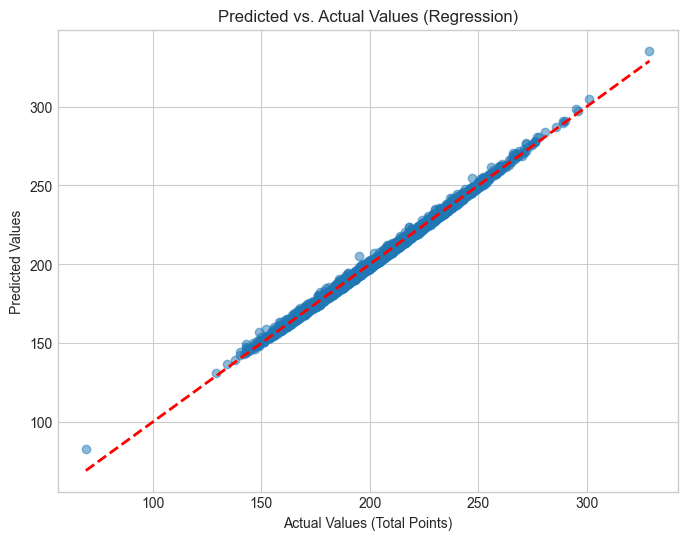

In [5]:
# Regression Model: Training and Evaluation

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

degree = 2
X_train_poly = polynomial_features(X_train_scaled, degree)
X_test_poly = polynomial_features(X_test_scaled, degree)

n_features = X_train_poly.shape[1]
theta_initial = np.zeros((n_features, 1))
learning_rate = 0.01
n_epochs = 1000

theta_final_reg, mse_history_reg = gradient_descent_reg(X_train_poly, y_train_reg.values.reshape(-1, 1), theta_initial, learning_rate, n_epochs)

y_pred_reg = predict_reg(X_test_poly, theta_final_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Regression Model Performance")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], '--r', linewidth=2)
plt.title('Predicted vs. Actual Values (Regression)')
plt.xlabel('Actual Values (Total Points)')
plt.ylabel('Predicted Values')
plt.show()

Top 10 Most Important Features for the Regression Model:
           Feature  Importance  Absolute_Importance
6         PTS_away   13.425635            13.425635
0         PTS_home   13.259691            13.259691
20   FT_PCT_away^2    0.307429             0.307429
14   FT_PCT_home^2    0.298881             0.298881
23      REB_away^2    0.282481             0.282481
17      REB_home^2    0.269113             0.269113
16      AST_home^2    0.243856             0.243856
22      AST_away^2    0.236872             0.236872
15  FG3_PCT_home^2    0.207718             0.207718
2      FT_PCT_home    0.207001             0.207001


C:\Users\Nikola\AppData\Local\Temp\ipykernel_8008\1603066213.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_reg.head(15), palette='viridis')


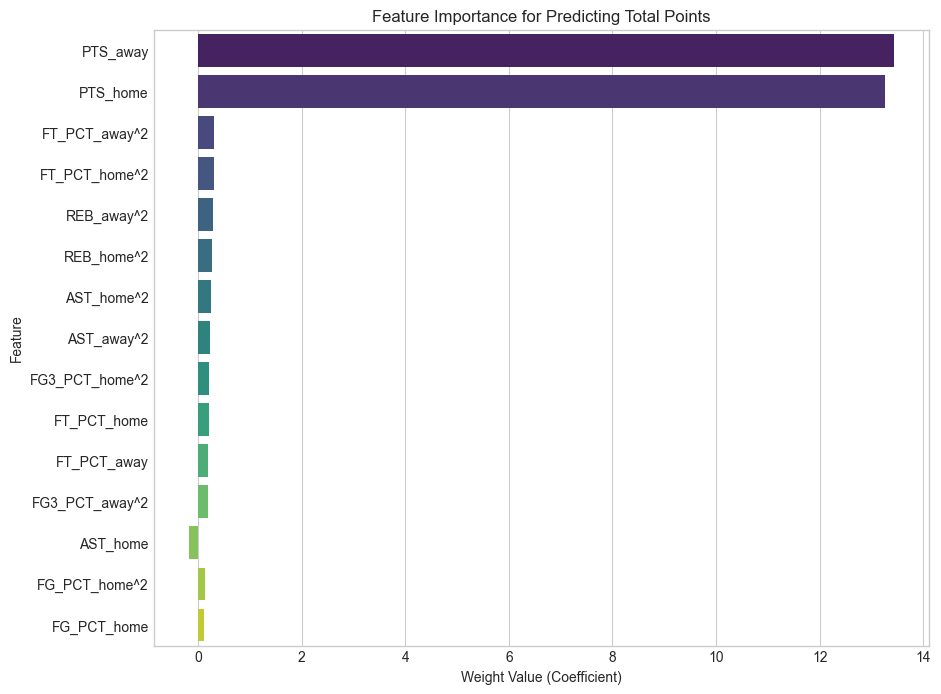

In [6]:
# Regression Model: Feature Importance Analysis

original_features = X.columns.tolist()
feature_names = ['BIAS'] + original_features + [f'{col}^2' for col in original_features]

weights = theta_final_reg.flatten()[1:]
feature_names_no_bias = feature_names[1:]

importance_df_reg = pd.DataFrame({
    'Feature': feature_names_no_bias,
    'Importance': weights
})

importance_df_reg['Absolute_Importance'] = importance_df_reg['Importance'].abs()
importance_df_reg = importance_df_reg.sort_values(by='Absolute_Importance', ascending=False)

print("Top 10 Most Important Features for the Regression Model:")
print(importance_df_reg.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_reg.head(15), palette='viridis')
plt.title('Feature Importance for Predicting Total Points')
plt.xlabel('Weight Value (Coefficient)')
plt.ylabel('Feature')
plt.show()

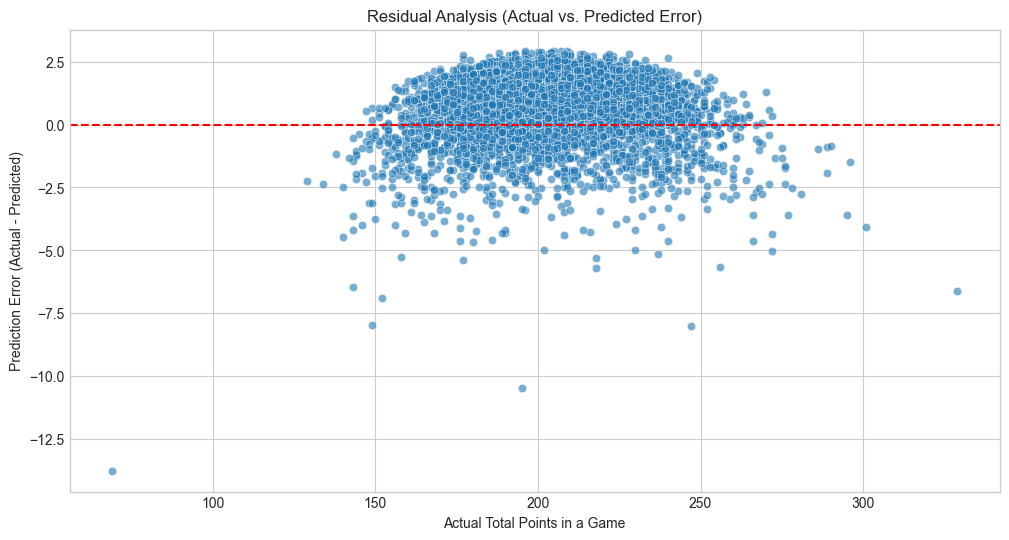

In [7]:
# Regression Model: Residual Analysis

residuals = y_test_reg - y_pred_reg.flatten()

residuals_df = pd.DataFrame({
    'Actual_Points': y_test_reg,
    'Predicted_Points': y_pred_reg.flatten(),
    'Residuals': residuals
})

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Actual_Points', y='Residuals', data=residuals_df, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis (Actual vs. Predicted Error)')
plt.xlabel('Actual Total Points in a Game')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.show()

Classification Model Performance
Accuracy: 0.97
Precision: 0.94
Recall: 0.95
F1-score: 0.95


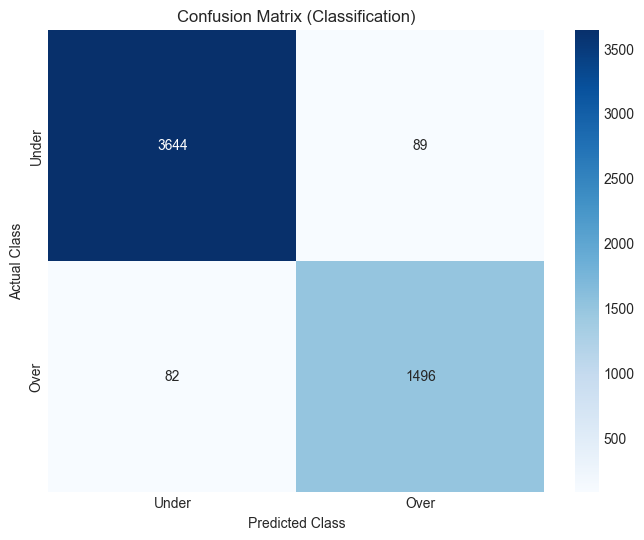

In [8]:
# Classification Model: Training and Evaluation

X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

degree = 2
X_train_poly = polynomial_features(X_train_scaled, degree)
X_test_poly = polynomial_features(X_test_scaled, degree)

n_features = X_train_poly.shape[1]
theta_initial = np.zeros((n_features, 1))
learning_rate = 0.1
n_epochs = 1000
lambda_reg = 0.1

theta_final_clf, bce_history_clf = gradient_descent_clf(X_train_poly, y_train_clf.values.reshape(-1, 1), theta_initial, learning_rate, n_epochs, lambda_reg)

y_proba_clf = predict_proba_clf(X_test_poly, theta_final_clf)
y_pred_clf = (y_proba_clf >= 0.5).astype(int)

accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)

print("Classification Model Performance")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Under', 'Over'], yticklabels=['Under', 'Over'])
plt.title('Confusion Matrix (Classification)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

Top 10 Most Important Features for the Classification Model:
          Feature  Importance  Absolute_Importance
6        PTS_away    2.618281             2.618281
0        PTS_home    2.600677             2.600677
18     PTS_away^2    0.661450             0.661450
7     FG_PCT_away    0.660802             0.660802
1     FG_PCT_home    0.648952             0.648952
12     PTS_home^2    0.612969             0.612969
11       REB_away    0.399623             0.399623
5        REB_home    0.395213             0.395213
19  FG_PCT_away^2   -0.218857             0.218857
13  FG_PCT_home^2   -0.204267             0.204267


C:\Users\Nikola\AppData\Local\Temp\ipykernel_8008\894400336.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_clf.head(15), palette='plasma')


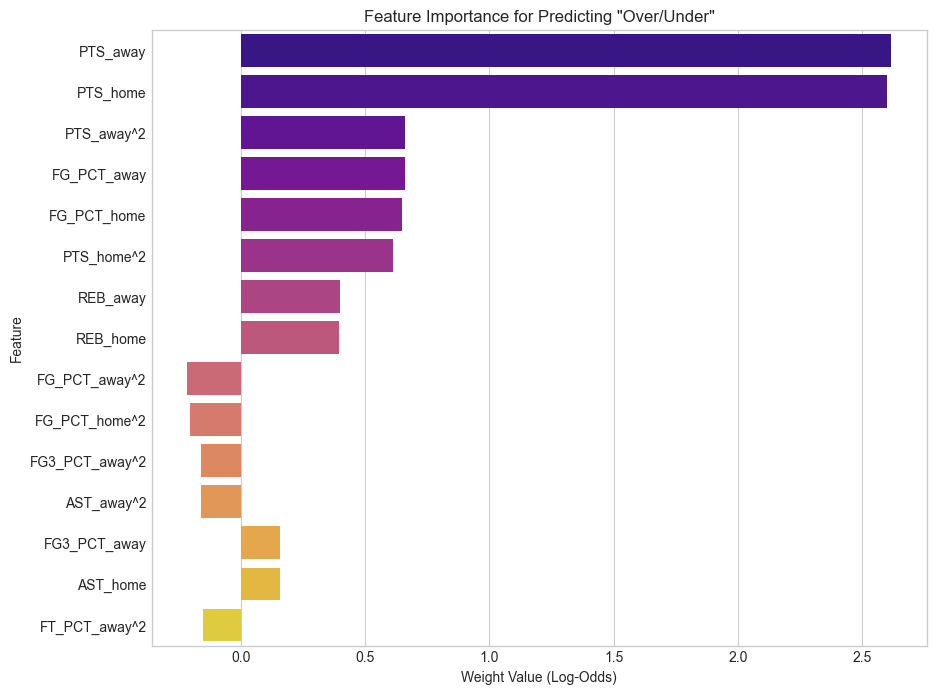

In [9]:
# Classification Model: Feature Importance Analysis

weights_clf = theta_final_clf.flatten()[1:]

importance_df_clf = pd.DataFrame({
    'Feature': feature_names_no_bias,
    'Importance': weights_clf
})

importance_df_clf['Absolute_Importance'] = importance_df_clf['Importance'].abs()

importance_df_clf = importance_df_clf.sort_values(by='Absolute_Importance', ascending=False)

print("Top 10 Most Important Features for the Classification Model:")
print(importance_df_clf.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_clf.head(15), palette='plasma')
plt.title('Feature Importance for Predicting "Over/Under"')
plt.xlabel('Weight Value (Log-Odds)')
plt.ylabel('Feature')
plt.show()

In [10]:
# Cross-Validation for Regression Model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

X_scaled = scaler.fit_transform(X)

for train_index, val_index in kf.split(X_scaled):
    X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
    y_train_cv, y_val_cv = y_reg.iloc[train_index], y_reg.iloc[val_index]
    
    X_train_poly_cv = polynomial_features(X_train_cv, degree=2)
    X_val_poly_cv = polynomial_features(X_val_cv, degree=2)
    
    n_features_cv = X_train_poly_cv.shape[1]
    theta_init_cv = np.zeros((n_features_cv, 1))
    
    theta_final_cv, _ = gradient_descent_reg(X_train_poly_cv, y_train_cv.values.reshape(-1, 1), theta_init_cv, 0.01, 1000)
    
    y_pred_cv = predict_reg(X_val_poly_cv, theta_final_cv)
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))

print("Cross-Validation (Regression)")
print(f"RMSE scores per fold: {[f'{score:.2f}' for score in rmse_scores]}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")


# Cross-Validation for Classification Model

f1_scores = []

for train_index, val_index in kf.split(X_scaled):
    X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
    y_train_cv, y_val_cv = y_clf.iloc[train_index], y_clf.iloc[val_index]
    
    X_train_poly_cv = polynomial_features(X_train_cv, degree=2)
    X_val_poly_cv = polynomial_features(X_val_cv, degree=2)
    
    n_features_cv = X_train_poly_cv.shape[1]
    theta_init_cv = np.zeros((n_features_cv, 1))
    
    theta_final_cv, _ = gradient_descent_clf(X_train_poly_cv, y_train_cv.values.reshape(-1, 1), theta_init_cv, 0.1, 1000, 0.1)
    
    y_pred_cv = (predict_proba_clf(X_val_poly_cv, theta_final_cv) >= 0.5).astype(int)
    f1_scores.append(f1_score(y_val_cv, y_pred_cv))

print("\nCross-Validation (Classification)")
print(f"F1-scores per fold: {[f'{score:.2f}' for score in f1_scores]}")
print(f"Average F1-score: {np.mean(f1_scores):.2f} (+/- {np.std(f1_scores):.2f})")

Cross-Validation (Regression)
RMSE scores per fold: ['1.46', '1.51', '1.40', '1.41', '1.44']
Average RMSE: 1.44 (+/- 0.04)

Cross-Validation (Classification)
F1-scores per fold: ['0.95', '0.95', '0.96', '0.95', '0.96']
Average F1-score: 0.95 (+/- 0.00)
